# Exploração dos dados do sistema elétrico

## Imports

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import re

## Paths

In [2]:
LINES_PATH = "../data/raw/electrical_grid/Linhas_de_Transmissão_-_Base_Existente.shp"
SUBSTATIONS_PATH = "../data/raw/electrical_grid/Subestações_-_Base_Existente.shp"
STATES_PATH = "../data/raw/state_lines/BR_UF_2024.shp"
BUFFER_OUTPUT_PATH = "../data/processed/buffer_rede_eletrica_10km.gpkg"

## Carregamento de Dados

In [3]:
linhas_gdf = gpd.read_file(LINES_PATH)
subestacoes_gdf = gpd.read_file(SUBSTATIONS_PATH)
states_gdf = gpd.read_file(STATES_PATH)
print("Dados carregados com sucesso!")

Dados carregados com sucesso!


## Inspeção Inicial dos Dados

In [4]:
print("\n--- Linhas de Transmissão ---")
print(f"CRS: {linhas_gdf.crs} | Quantidade: {len(linhas_gdf)}")
print(linhas_gdf.head())

print("\n--- Subestações ---")
print(f"CRS: {subestacoes_gdf.crs} | Quantidade: {len(subestacoes_gdf)}")
print(subestacoes_gdf.head())


--- Linhas de Transmissão ---
CRS: EPSG:4674 | Quantidade: 2094
                                                Nome  \
0  LT 500 kV Ventos de Santa Eugênia - Gentio do ...   
1                   LT 230 kV Açu III - Simplice, C1   
2            LT 230 kV Palmeiras - UTE Palmeiras, C1   
3  LT 230 kV Ventos do Piauí II - Curral Novo do ...   
4            LT 230 kV Alegrete 2 - Uruguaiana 5, C1   

                                          Concession  Tensao    Extensao  \
0                                         OSLO I S/A   500.0   59.649553   
1  TAESA - TRANSMISSORA ALIANÇA DE ENERGIA ELÉTRI...   230.0   52.481310   
2  PALMEIRAS CEPASA - Central Energética Palmeira...   230.0    0.620382   
3                                                  -   230.0    4.593088   
4  CEEE GT - Companhia Estadual de Geração e Tran...   230.0  127.042847   

   Ano_Opera         created_us created_da         last_edite last_edi_1  \
0       2022  BERNARDO.OLIVEIRA 2025-04-11  BERNARDO.OLIVEIRA 202

## Mapa Geral da Infraestrutura

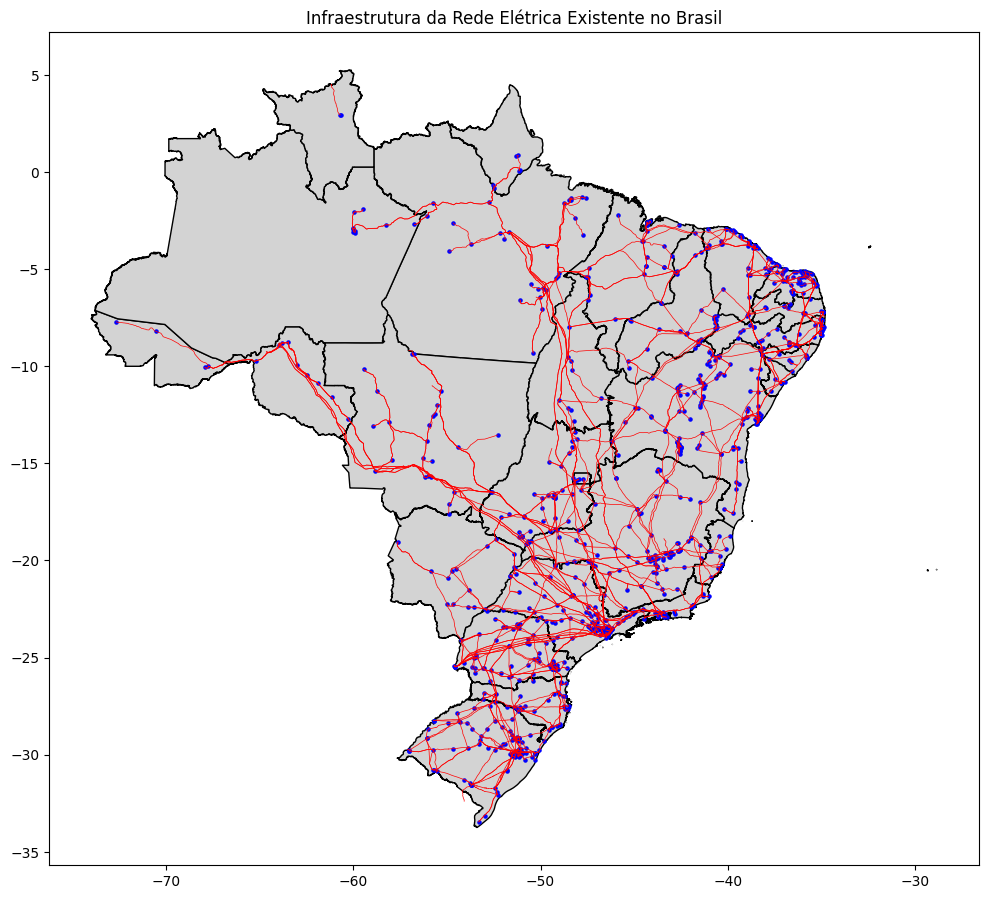

In [5]:
fig, ax = plt.subplots(figsize=(12, 12))
states_gdf.plot(ax=ax, color="lightgray", edgecolor="black")
linhas_gdf.plot(ax=ax, color="red", linewidth=0.5)
subestacoes_gdf.plot(ax=ax, marker="o", color="blue", markersize=5)
ax.set_title("Infraestrutura da Rede Elétrica Existente no Brasil")
plt.show()

## Criação do Buffer da Rede

In [6]:
print("Iniciando pré-processamento para criação do buffer...")
linhas_proj = linhas_gdf.to_crs(epsg=31983)
subestacoes_proj = subestacoes_gdf.to_crs(epsg=31983)

linhas_proj["Tensao_num"] = pd.to_numeric(linhas_proj["Tensao"], errors="coerce")
linhas_alta_tensao = linhas_proj[linhas_proj["Tensao_num"] >= 230].copy()

buffer_linhas = linhas_alta_tensao.buffer(10000)
buffer_subestacoes = subestacoes_proj.buffer(10000)

buffer_total_linhas = buffer_linhas.unary_union
buffer_total_subestacoes = buffer_subestacoes.unary_union
buffer_final = buffer_total_linhas.union(buffer_total_subestacoes)
print("Buffer final criado.")

Iniciando pré-processamento para criação do buffer...


C:\Users\JPMar\AppData\Local\Temp\ipykernel_18232\2835420367.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_total_linhas = buffer_linhas.unary_union


Buffer final criado.


C:\Users\JPMar\AppData\Local\Temp\ipykernel_18232\2835420367.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_total_subestacoes = buffer_subestacoes.unary_union


### Mapa do Buffer

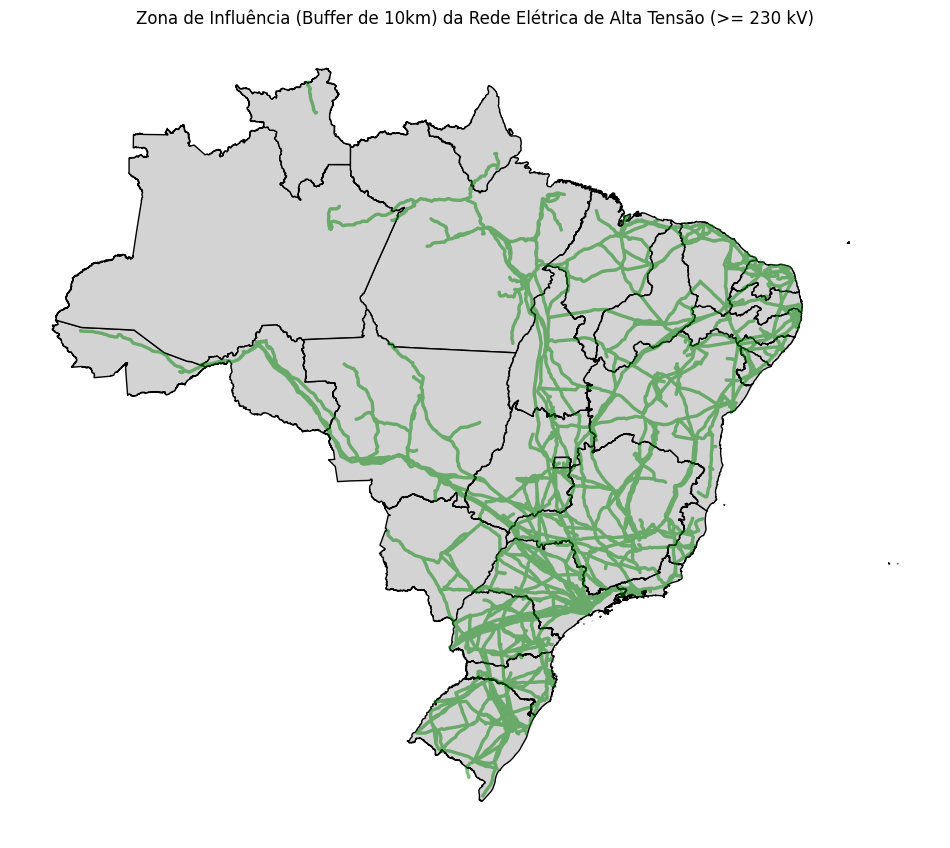

In [7]:
states_proj = states_gdf.to_crs(epsg=31983)  # Reprojetar estados para o plot
fig, ax = plt.subplots(figsize=(12, 12))
states_proj.plot(ax=ax, color="lightgray", edgecolor="black")
gpd.GeoSeries([buffer_final]).plot(ax=ax, color="green", alpha=0.5)
ax.set_title(
    "Zona de Influência (Buffer de 10km) da Rede Elétrica de Alta Tensão (>= 230 kV)"
)
ax.set_axis_off()
plt.show()

## Salvamento dos dados do Buffer

In [8]:
buffer_gdf_proj = gpd.GeoDataFrame(geometry=[buffer_final], crs="EPSG:31983")
buffer_gdf_final = buffer_gdf_proj.to_crs(epsg=4674)
buffer_gdf_final.to_file(BUFFER_OUTPUT_PATH, driver="GPKG")
print(f"Buffer salvo em {BUFFER_OUTPUT_PATH} com CRS {buffer_gdf_final.crs}")

Buffer salvo em ../data/processed/buffer_rede_eletrica_10km.gpkg com CRS EPSG:4674


# Seção Extra / Curiosidade
## Rede Elétrica como um Grafo
### Após a visualização da topologia da rede elétrica, percebi que é um grafo, então decidi ver se existiam cliques por curiosidade.

## Código da Análise de Cliques

In [ ]:
substation_name_map = {
    name.replace("SE ", ""): name for name in subestacoes_gdf["Nome"]
}
clean_substation_names = list(substation_name_map.keys())

G = nx.Graph()
G.add_nodes_from(list(subestacoes_gdf["Nome"]))

edges_added = 0
for line_name in linhas_gdf["Nome"]:
    connected_nodes_clean = []
    for clean_name in clean_substation_names:
        if re.search(r"\b" + re.escape(clean_name) + r"\b", line_name, re.IGNORECASE):
            connected_nodes_clean.append(clean_name)

    if len(connected_nodes_clean) == 2:
        original_node_1 = substation_name_map[connected_nodes_clean[0]]
        original_node_2 = substation_name_map[connected_nodes_clean[1]]
        G.add_edge(original_node_1, original_node_2)
        edges_added += 1

print("\n--- Análise de Grafo ---")
print(f"Grafo criado com {G.number_of_nodes()} nós e {edges_added} arestas.")

if edges_added > 0:
    cliques = list(nx.find_cliques(G))
    significant_cliques = [clique for clique in cliques if len(clique) >= 3]
    significant_cliques.sort(key=len, reverse=True)

    print(
        f"Encontradas {len(significant_cliques)} cliques significativas (3+ subestações):"
    )
    for i, clique in enumerate(significant_cliques[:10]):
        print(f"  Clique #{i + 1} (Tamanho: {len(clique)}): {clique}")
else:
    print("Nenhuma clique encontrada.")

## Mapa das Cliques 

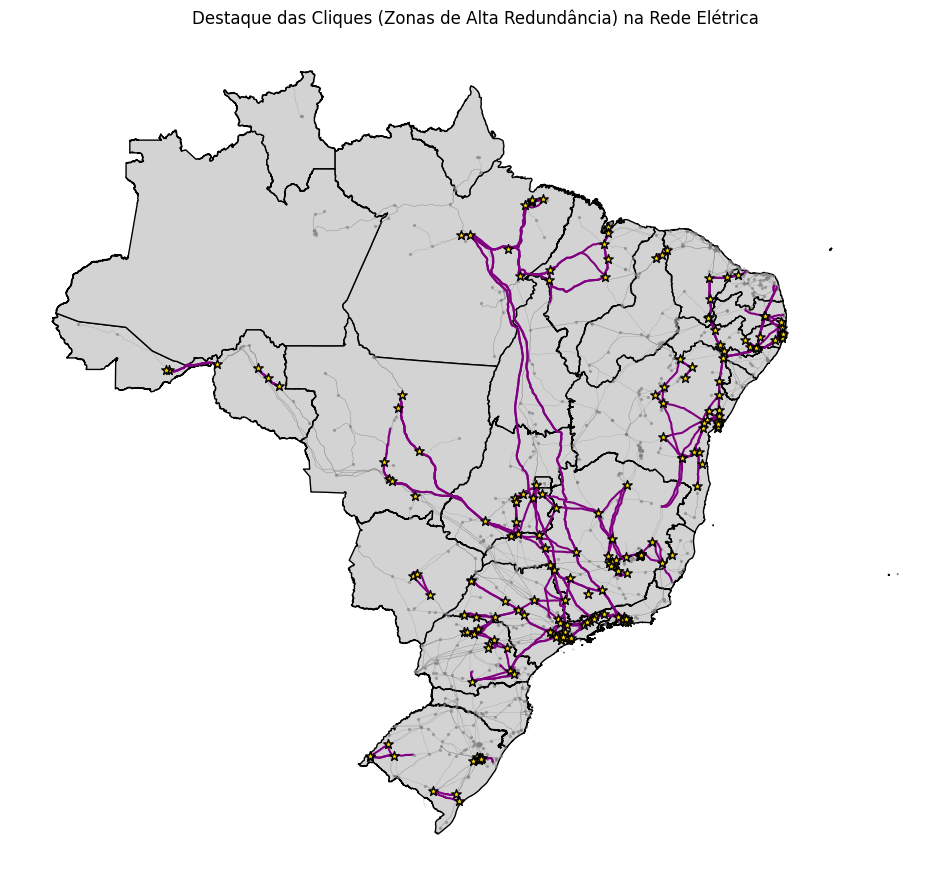

In [ ]:
# Passo 1: Obter uma lista única de todas as subestações que estão em alguma clique
if "significant_cliques" in locals() and len(significant_cliques) > 0:
    clique_nodes = set()
    for clique in significant_cliques:
        for node in clique:
            clique_nodes.add(node)

    # Passo 2: Filtrar os GeoDataFrames para manter apenas os elementos das cliques
    clique_substations_gdf = subestacoes_gdf[subestacoes_gdf["Nome"].isin(clique_nodes)]

    # Filtrar as linhas que conectam as subestações das cliques (lógica um pouco mais complexa)
    clique_lines_gdf = linhas_gdf[
        linhas_gdf["Nome"].apply(
            lambda line_name: sum(
                1 for node in clique_nodes if node.replace("SE ", "") in line_name
            )
            >= 2
        )
    ]

    # Passo 3: Criar o mapa destacando as cliques
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plotar o mapa base
    states_gdf.plot(ax=ax, color="lightgray", edgecolor="black")

    # Plotar a rede completa em cinza claro para dar contexto
    linhas_gdf.plot(ax=ax, color="gray", linewidth=0.3, alpha=0.5)
    subestacoes_gdf.plot(ax=ax, marker="o", color="gray", markersize=2, alpha=0.5)

    # Plotar os componentes das cliques com destaque
    clique_lines_gdf.plot(ax=ax, color="purple", linewidth=1.5, zorder=3)
    clique_substations_gdf.plot(
        ax=ax, marker="*", color="gold", markersize=50, zorder=4, edgecolor="black"
    )

    ax.set_title("Destaque das Cliques (Zonas de Alta Redundância) na Rede Elétrica")
    ax.set_axis_off()
    plt.show()

else:
    print("Nenhuma clique significativa foi encontrada para plotar.")